# Final Take-home exam
# YourUserID: xxxxxxxx
## General 
The instruction for the final exam for IS2002B is included in this Jupyter Notebook. 
Some basic rules: 
- You are allowed to use any document and source on your computer and look up documents on the internet. 
- You or not allowed to share documents, or communicate in any other way with people about the final during the 24hr period of the take home final. 
- You are only allowed to use the packages listed under "preliminaries" - the use of other regression or machine learning toolboxes is not permitted. 
- All the code you are using from previous Assignments or Labs need to be included in the notebook. 
- All questions also require some written answer. The answer to these questions should be given in full English sentences. 
- All Figures should be appropriately labeled and should have a figure caption. 
- The Final exam needs to be submitted on OWL (Test + Quizzes) within 4 hrs of the time you first assessed this document.

## Preliminaries

In [12]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as ss
import pandas as pd 
import numpy as np
import scipy.optimize as so
import seaborn as sb
import statsmodels.formula.api as smf

In [13]:
def simpleRegPredict(b,x):
    yp=b[0]+b[1]*x
    return yp 

def simpleRegLossRSS(b,x,y):
    predY = simpleRegPredict(b,x)
    res = y-predY
    rss = sum(res**2)
    deriv = np.zeros(2)
    deriv[0]=-2*sum(res)
    deriv[1]=-2*sum(res*x)
    return (rss,deriv)

def simpleRegLossSAD(b,x,y):
    predY = simpleRegPredict(b,x)
    res = y-predY
    sad = sum(res.abs())
    deriv = np.zeros(2)
    deriv[0]=-sum(np.sign(res))
    deriv[1]=-sum(np.sign(res)*x)
    return (sad,deriv)

def plotPrediction(b,x,y,predfcn):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    xp = np.linspace(min(x),max(x),num=50)
    yp = predfcn(b,xp)
    ax.plot(xp,yp,'r')
    
def simpleRegFit(x,y,lossFcn=simpleRegLossRSS):
    b0=[np.mean(y),0]
    RES = so.minimize(lossFcn,b0,args=(x,y),jac=True)
    b=RES.x # Results
    plotPrediction(b,x,y,simpleRegPredict)
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,grad = simpleRegLossRSS(b,x,y)
    R2 = 1-RSS/TSS 
    return (R2,b)

def addPrediction(b,x,predFunc,ax,linestyle='r:'):
    xrange = max(x)-min(x)
    xp = np.linspace(min(x)-xrange/30,max(x)+xrange/30,num=50)
    yp = predFunc(b,xp)
    ax.plot(xp,yp,linestyle)
    return(ax)
    


def multRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value 
    return yp 

def multRegLossRSS(b,D,y,xname):
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname):
    N=len(xname)
    b0=np.zeros((N+1,1))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS 
    return (b,R2)

def smMultReg(df,yname,xform):
    formula = yname + ' ~ ' + xform 
    # call the statsmodels and fit the model
    model_fit = smf.ols(formula, data = df).fit()

    # get the parameters and convert it to numpy array
    #print(type(model_fit.params))
    coefs = np.array(model_fit.params)
    #print(coefs[1]) # for debugging
    
    #print(model_fit.summary()) # for debugging
    # R2
    yp = model_fit.predict(D)
    y= D[yname]
    RSS = np.sum((y - yp)**2)
    TSS = np.sum((y - y.mean())**2)
    R2= 1- RSS/TSS
    R2
    return coefs, R2

def leaveOneOutCV(D,yname,xform):
    formula = yname + ' ~ ' + xform 
    N = len(D[yname]) #Number of observations 
    yp= np.zeros(N)
    ind = np.arange(N)
    #print(ind)
    for i in range(N):
        #print(type(df.loc[ind!=i]))
        model=smf.ols(formula,data=D.loc[ind!=i]).fit()
        yp[i]=model.predict(D.loc[ind==i])
        
    y = D[yname]
    TSS  = sum((y-y.mean())**2)
    RSS = sum((y-yp)**2)
    R2cv = 1-RSS/TSS
    return R2cv

def bootstrapReg(df,yname,xform,fitfcn=smMultReg,numIter=500):
    b, R2=fitfcn(df,yname, xform)
    numParams=len(b)
    N     = len(df.index)
    ind   = np.arange(N)
    stats = np.zeros((numIter,numParams))
    for i in range(numIter):
        sample = np.random.choice(ind,N)
        stats[i,:], R2 = fitfcn(df.iloc[sample],yname, xform)
    return stats

def confidenceInt(data,perc):
    Int=(np.percentile(data,(100-perc)/2),np.percentile(data,100-(100-perc)/2))
    return Int

## Data set

The data frame contains the total number of confirmed Covid-19 infections, number of recovered cases, and number death as of April 12th, across 96 countries. It also contains some basic socio-economic data from these countries. 
- Country: Name of the country 
- Continent: Asia, Europe, Africa, Australia, AmericaN, AmericaS. Middle American countries are counted as North 
- Tests: Total number of COVID-19 tests conducted. Countries where the number is not reported are labeled with 'NaN' (not-a-number)
- Density: Population density (people / km^2)
- UrbanPop: Percentage of people living in an Urban environment
- Restrictions: Social distancing restrictions in place (incomplete) 
- HospitalBed: Number of Hospital beds per 1000 inhabitants 
- Lung: Prevalence of chronic lung diseases (per 100,000)  
- MedianAge: Median Age of the population 
- GDP2018: Gross Domestic Product in US Dollars 
- CrimeIndex: Composite index from surveys about perceived crime. (0: lowest crime 100: highest crime)  
- Population2020: Population size (in units of 1000 people) 
- Smoking2016: Percentage of population that is smoking
- TotalInfected: Total number of confirmed COVID-19 cases, April 12th
- TotalDeath: Total number of COVID-19 death, April 12th
- TotalRecovered: Total number of fully recovered COVID-19 cases

## Task 1: Infection rate (40 pts)
In this task we are looking at infection rate across different countries. 
### Question 1 (3ts) 
Load the data set 'covid19_by_country.csv'. How many observations do you have? 
For how many countries do you have the numbers of Tests reported? Hint: you can determine whether a number is a 'NaN' using the function `np.isnan`.  

In [14]:
D = pd.read_csv('covid19_by_country.csv')
D2 = D.loc[np.isnan(D['Tests'])]
len(D2.index)

49

### Question 2  (6pts)
To calculate the infection rate, we need to normalize the number of TotalInfected by the population of the country (Population2020). Make a new column in the data frame, called 'InfectionRate', that codes for the number of COVID19 cases per 1000 people.
Plot a histogram of the distribution. 

Written answer: How would you characterize the distribution in terms of modality and skew? 

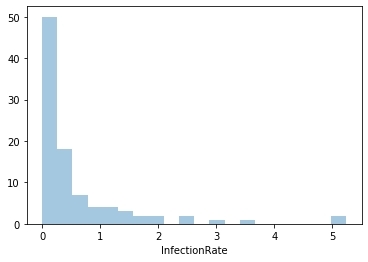

In [15]:
D['InfectionRate']= D.TotalInfected/D.Population2020
sb.distplot(D.InfectionRate,kde=None)

* Histogram of COVID19 infection rate across 96 countries. 

*New variable correctly calculate (2pt)
Figure + Caption (2pts)*

Infection rate is a strongly right-skewed distribution (1pt). Although the two observations of 5 cases / 1000 are outlying, the distribution is best described as unimodal. (1pt)


### Question 3 (5pts)
Let's look at how to explain the differences in the Infection rates. 

First, let's consider how wealthy different countries are. For this, first use the variables GDP2018 (total GDP in $) and Population2020 (total population in 1000) to calculate the GDP per person. Assign it to a new column in the Data Frame. Make a scatterplot of GDP per person (x-axis) and Infection Rate (y-axis). 

Written answer: What relationship do you observe? Give at least 2 possible reasons that could explain such a relationship. 


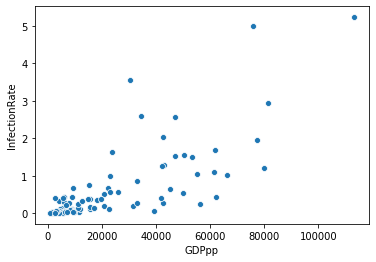

In [16]:
D['GDPpp']= D.GDP2018/D.Population2020/1000 
sb.scatterplot(D.GDPpp,D.InfectionRate)

Scatterplot of GDP per person and Infection rate (per 1000) people. 

*New variable correctly calculate (1pt)
Figure + Caption (1pts)*

There is a positive relationship (1pt), Possible reasons: (2pts total) 
- Higher GDP, more travel and chance to import the virus from China 
- Higher GDP is associate with more urban population, which helps the virus spread 
- Europe and North America are harder hit, which also coincidentally higher GDP. Relationship is indirect.  
- Richer Countries test mode - therefore have higher case numbers

### Question 4 (5pts)
Fit a simple linear regression model, explaining Infection rate by the GDP per person. 
Report the R2 value of the fit. 

Then plot the data and the prediction line. Don't forget the Figure caption. 

R2: 0.5691853524422479


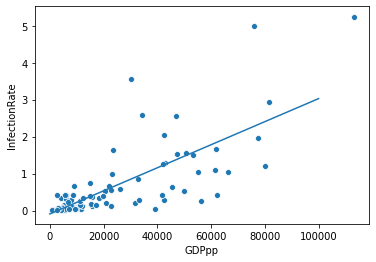

In [17]:
b,R2 = multRegFit(D,D.InfectionRate,['GDPpp'])
print('R2:', R2)
sb.scatterplot(D.GDPpp,D.InfectionRate)
x = np.linspace(0,100000,20)
y = b[0]+b[1]*x
plt.plot(x,y)

### Question 5 (6pts)
Calculate the residuals of the fit from Question 4. Identify and list the countries that have a residual of more than 1 case/1000, i.e. countries that lie way above the line. 

Written answer: What do all these countries have in common? 

In [18]:
res = D.InfectionRate-b[0]-b[1]*D.GDPpp
D[res>1]

,Country,Continent,Tests,Density,UrbanPop,Restrictions,HospitalBed,Lung,MedianAge,GDP2018,CrimeIndex,Population2020,Smoking2016,TotalInfected,TotalDeaths,TotalRecovered,InfectionRate,GDPpp
10,Belgium,Europe,4225.0,383,98,1,6.2,27.11,41.4,5.430000e+11,42.50,11589.623,28.2,29647,3600,6463,2.558064,46852.257403
37,Iceland,Europe,2278.0,3,94,0,3.2,19.71,36.5,2.587848e+10,23.15,341.243,14.7,1701,8,889,4.984718,75835.916810
42,Italy,Europe,148657.0,206,69,1,3.4,17.00,45.5,2.080000e+12,44.35,60461.826,23.7,156363,19899,34211,2.586144,34401.872018
52,Luxembourg,Europe,NaN,242,88,0,4.8,20.52,39.3,7.088533e+10,30.17,625.978,23.5,3281,66,500,5.241398,113239.324518
82,Spain,Europe,NaN,94,80,1,3.0,16.37,42.7,1.420000e+12,31.07,46754.778,29.3,166831,17209,62391,3.568213,30371.227514


*Calculate residuals correctly (2pts)* 
*Find the right countries (2pts)*  

All the 5 countries that have residuals > 1 are in Europe. (2pts)

### Question 6 (8pts)
Let's investigate whether the relationship between GDP per person and infection rate still holds when we account for the geographical region. 
* First, make a dummy-coded variable that indicates whether the country is in Europe or not (using variable Continent)
* Second, restrict the data to European and North American countries. *Hint: If you want a vector of True/False values that indicates whether a column in the data frame (D.col) equals A OR B, you can use  `np.logical_or(D.col==A,D.col==B)`*
* Using this restricted data, fit a regression model, using the dummy-coded variable (Europe vs. N. America) and GDP per person as regressors. 
* Make a scatterplot of GDP per person against infection rates, with different color dots for European and North American countries. In the same plot, add seperate regression lines for North America and Europe from the model that you fit.

R2 is 0.59


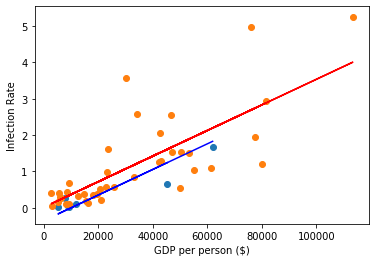

In [20]:
D['isEurope']=np.double(D.Continent=="Europe")
R=D[np.logical_or(D.Continent=='Europe',D.Continent=='AmericaN')]
# Rp = D.loc[(D.Continent=='Europe') | (D.Continent=='AmericaN')]
plt.scatter(D2.GDPpp[D2.isEurope==0],D2.InfectionRate[D2.isEurope==0])
plt.scatter(D2.GDPpp[D2.isEurope==1],D2.InfectionRate[D2.isEurope==1])
b,R2=smMultReg(R,'InfectionRate','isEurope + GDPpp')
yp = multRegPredict(b,D2,['isEurope','GDPpp'])
plt.plot(D2.GDPpp[D2.isEurope==0],yp[D2.isEurope==0],'b-')
plt.plot(R.GDPpp[D2.isEurope==1],yp[D2.isEurope==1],'r-')
plt.xlabel('GDP per person ($)')
plt.ylabel('Infection Rate')
print("R2 is {0:3.2f}".format(R2))

*Grading: 
* Dummy coding (2pts)
* Restriction (2pts)
* Fit correct regression (2pts)
* Plot, prediction and caption (2pts)

### Question 7 (7pts)
Use Bootstrap analysis to determine whether the relationship between GDP per person and Infection rate is significant when we account for whether the country is North American or European. Again, limit the analysis to North-American and European countries only.

Tip: Because the regression weights for GDP are so small, you may have to multiply the Beta coefficient by 10000 when you inspect your confidence interval with rounding. 

Written answer: What do you conclude from the bootstrap in terms of the significance of a relationship between GDP and ? What claims can you make? 

In [21]:
B=bootstrapReg(D2,'InfectionRate','isEurope + GDPpp',smMultReg)
Int1=confidenceInt(B[:,1],95)
Int2=confidenceInt(B[:,2]*10000,95)
print("Confidence interval for influence of Continent {0:3.2f}-{1:3.2f}".format(Int1[0],Int1[1]))
print("Confidence interval for influence of GDP {0:3.3f}-{1:3.3f}".format(Int2[0],Int2[1]))

Confidence interval for influence of Continent 0.06-0.71
Confidence interval for influence of GDP 0.225-0.458


*Grading Bootstrap 3pts, Confidence Int 2pts)*

Even when we account for geographical region (continent) the influence of GDP on Infection rates stays significant, with higher Infection rates for Richer countries. (2pts)

## Task 2: Nonlinear model of Infection rate (30 pts)
### Question 1 (5pts)
Fit a linear regression model for the Infection rate (y-variable) as a linear function of UrbanPop (x-variable). 
Make a scatter plot of the two variables and draw in the regression line. 

Written answer: Have a look at he fit of the linear model. Which aspect of these predicted values does not respect the natural constraints of the data - i.e. where does the model make predictions that cannot possibly be true?    

In [ ]:
b,R2 = multRegFit(D,D.InfectionRate,['UrbanPop'])
sb.scatterplot(D.UrbanPop,D.InfectionRate)
x = np.linspace(15,100,20)
Dp = pd.DataFrame({'UrbanPop':x})
y = multRegPredict(b,Dp,['UrbanPop'])
plt.plot(x,y)

*Figure* Linear model of Infection rate as a function of percentage Urban population


*Regression fit: 1pts 
Plot: 2pts*

Predictions of infection rates for low Urban Population is negative - this is impossible, as infection rates cannot be negative. (2pts)

### Question 2 (7pts)
To improve the the model, let's build an exponential model of the Infection rate. Start with your multiple regression function `multRegPredict`. Modify the funtion so that the predicted infection rate is

$InfectionRate = exp (b_0 + b_1 * UrbanPop)$ 

Make sure you give the new function a new name. Using the function, plot the prediction for $b_0= -4, b_1 = 0.05$, superimposed on the the scatter plot of UrbanPop (x) vs. InfectionRate.  

In [ ]:
def multRegPredictExp(b,D,xname):
    yp=np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value 
    return np.exp(yp)

sb.scatterplot(D.UrbanPop,D.InfectionRate)
b=np.array([-4,0.05])
x = np.linspace(15,100,20)
Dp = pd.DataFrame({'UrbanPop':x})
y = multRegPredictExp(b,Dp,['UrbanPop'])
plt.plot(x,y)

### Question 3 (8pts)
Question 3 and 4 in this task are quite difficult. To make sure that you have enough time to finish the final, it may be best if you first complete all the other Questions (including Task 3) and then return to Question 3 + 4 in the end.  
In this Question we will fit the new nonlinear model, using a sum-of-squares loss function. Precisely, we want to minimize the loss-function: 

$J = \sum_{n}{(InfectionRate_n - exp (b_0 + b_1 * UrbanPop_n))^2}$ 


In Question 3 we will do so without the Gradient, in Question 4, you will add the Gradient back in. 
So, start with the function `multRegLossRSS` from Assignment 10 solutions. 

Now use your function from Question 2 as the predict function. For this question, remove the gradient from your function and let it only return the residual sums of squares as loss. 

Then modify `multRegFit` from the Assignment 10 solutions to call the new loss function. When calling `so.minimize`, make sure that you set `jac=False`. 

Then fit the model with your new function, and plot the prediction line onto the scatter plot. 


Written answer 1: Was the fit successful?  
Written answer 2: What does the `jac=False` option do? 


In [ ]:
def multRegLossRSSExp(b,D,y,xname):
    predY = multRegPredictExp(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    # grad = grad * predY
    return (rss)

def multRegFitExp(D,y,xname):
    N=len(xname)
    b0=np.zeros((N+1,1))
    RES = so.minimize(multRegLossRSSExp,b0,args=(D,y,xname),jac=False)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS = multRegLossRSSExp(b,D,y,xname)
    R2 = 1-RSS/TSS 
    return (b,R2)

b,R2 = multRegFitExp(D,D.InfectionRate,['UrbanPop'])
sb.scatterplot(D.UrbanPop,D.InfectionRate)
y = multRegPredictExp(b,Dp,['UrbanPop'])
plt.plot(x,y)

 The fit was not successfull, as the gradient was not provided, so unclear how much it can be trusted. (1pt)
 The `jac=False` tells so.optimize not to expect a gradient (Jacobian). (1pt)

### Question 4: Add the derivative (10pts)
Now calculate and report the two derivatives $\frac{\partial J}{\partial b_0}$, and $\frac{\partial J}{\partial b_1}$. Check your notes from Lecture 7! 

Also, remember $\frac{\partial exp(x)}{\partial x}=exp(x)$. 

Now add the derivative back into your loss function and let it return the gradient. Refit the model, remembering to set the option `jac=True`, when you call the optimizer. 

Again plot the fit. Was the fit this time successful? 

$J = \sum_{n}{(y_n - exp (b_0 + b_1 * x_n))^2}$ 

$\frac{\partial J}{\partial b_0} = -2\sum_{n}{(y_n - exp (b_0 + b_1 * x_n)*exp (b_0 + b_1 * x_n))}$

$\frac{\partial J}{\partial b_1} = -2\sum_{n}{(y_n - exp (b_0 + b_1 * x_n)*x_n*exp (b_0 + b_1 * x_n))}$.

In [ ]:
def multRegLossRSSExp(b,D,y,xname):
    predY = multRegPredictExp(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res* predY)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res * predY)
    return (rss,grad)

def multRegFitExp(D,y,xname):
    N=len(xname)
    b0=np.zeros((N+1,1))
    RES = so.minimize(multRegLossRSSExp,b0,args=(D,y,xname),jac=True)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,R2 = multRegLossRSSExp(b,D,y,xname)
    R2 = 1-RSS/TSS 
    return (b,R2)

b,R2 = multRegFitExp(D,D.InfectionRate,['UrbanPop'])
sb.scatterplot(D.UrbanPop,D.InfectionRate)
y = multRegPredictExp(b,Dp,['UrbanPop'])
plt.plot(x,y)

The fit was time time successful. 

## Task 3: Modeling mortality rate (30pts)
Estimates of the mortality rate associated with COVID19 are still very uncertain, and differ dramatically between different countries. In this task we will investigate the issues connected with estimating mortality rates. 

### Question 1 (4pts)
The mortality rate of a disease is defined as the probability that a patient will die, given that he or she contracted the disease. 

Generate a crude estimate for the Mortality rate *for each* Country by dividing the Total number of reported Deaths by the Total number of confirmed cases.

Make a histogram of the mortality estimates across countries. How would you describe the distribution in terms of skew and modality?  

In [ ]:
D['Mortality']= D.TotalDeaths/D.TotalInfected
sb.distplot(D.Mortality)

Histogram of COVID19 mortality rates across countries. 

*Calculation (1pt), Plot (1pt)*
The distribution is right-skewed (1pt) and possibly bi-modal with one mode around 0 and one around 0.1. (1pt)

### Question 2  (6pts)
Why may TotalDeaths/TotalInfected not be a good estimator for the true mortality rate? See the definition of Mortality rate in question 1. Name at least 1 factor that could make your estimate lower than the true mortality rate, and 1 factor that would make the estimate higher than the true mortality rate. For each factor you describe, explain what data a research team could realistically acquire within a month of work to make the estimate of mortality better.

Underestimate 
- Currently confirmed cases may still die: Track the currently infected patients for a month and see who will die. 
- Not all COVID19 related death maybe reported as such: Look at increases in Mortality rate overall in comparision to previous years, to figure out how many cases may be unreported. 

Overestimate: 
- There may be many more (asymptomatic or mild) infections than the confirmed ones: Randomly sample or test everybody in a given population and compare this positive rate to previously confirmed number of cases. 

*For each good reason 2pt, 1pt for fix* 

### Question 3  (7pts)
Let's now use the GDP per person and Infection rate as predictors for our estimate of mortality rate. When interpreting results, remember from Task 1 that there is a positive correlation between the GPD per person and the Infection rate across countries. 

Now fit 3 linear models: 
1. Explaining Mortality Rate (as defined in T3,Q1) as a linear function of GDP per person (as defined in T1, Q3)
2. Explaining Mortality Rate (as defined in T3,Q1) as a linear function of Infection rate (as defined in T1, Q3)
3. Explaining Mortality Rate as a linear function of both GDP per person and Infection rate. 

For each model (1-3), report the fitted coefficients for GDP per person and Infection Rate (denoting which variables they belong to) and the fitted R2. 

Written answer: does the sign of the coefficient for GDP per person switch when you move from model 1 to model 3? What does this mean for the influence of GDP on Mortality rate? Looking at the R2-values for all three models, what phenonon do you observe here? 

In [ ]:

b,R2 = smMultReg(D2,'Mortality','GDPpp')
print('Model1: ', round(R2,4))
print('GDPpp:',round(b[1],8))

b,R2 = smMultReg(D2,'Mortality','InfectionRate')
print('Model2', round(R2,4))
print('InfRate:',round(b[1],5))
      
b,R2 = smMultReg(D2,'Mortality','InfectionRate + GDPpp')
print('Model3', round(R2,4))
print('InfRate:',round(b[1],5))
print('GDPpp:',round(b[2],8))


*per correctly fitted model 1 pt* 

The Sign of the GDP regression coefficient goes from positive to negative in the full model. (1pt) That means, once accounting fo infection rate, high GDP is actually a predictor of low mortality. (1pt) Because the R2 of the joint model is larger than the summed R2 of the single models, we are looking at suppression. (2pt)  

### Question 4 (6pts)
In this question, we will try to build a model that can predict Mortality rate in a cross-validated fashion.

Use leave-one-out crossvalidation to determine what is the most appropriate model of Mortality Rate across different countries. 

Start with evaluating the model that explains Mortality of Infection Rate and GDP per person. Report the cross-validated R2. What do you conclude from this number? 

In [ ]:
R2cv = leaveOneOutCV(D,'Mortality','InfectionRate + GDPpp')
print('Crossvalidated R2:',round(R2cv,4))

*(3pt) for correct crossvalidation*

The negative R2 shows that the model does not predict he data better than just predicting the mean Mortality rate. (3pt)

### Question 5 (7pts)
Now consider the following three linear models to fit the Mortality rate and report cross-validated R2 for each of them. 
The models should containt (additionally to the intercept) the following linear terms:
1. MedianAge 
2. InfectionRate, HospitalBed
3. InfectionRate, HospitalBed, Product of InfectionRate and HospitalBed  

Written answer: What do you conclude? What is the problem especially with the last model?  
    

In [ ]:
R2cv = leaveOneOutCV(D,'Mortality','MedianAge')
print('Crossvalidated R2:',round(R2cv,4))

In [ ]:
R2cv = leaveOneOutCV(D,'Mortality','InfectionRate + HospitalBed')
print('Crossvalidated R2:',round(R2cv,4))

In [ ]:
R2cv = leaveOneOutCV(D,'Mortality','InfectionRate + HospitalBed + InfectionRate*HospitalBed ')
print('Crossvalidated R2:',round(R2cv,4))

*1 pt for each correct R2CV*

All Models return negative predictive R2 - especially the last model overfits the data. (2pts) Probably the lack of good controlled estimates of Mortality rates limits the usefulness of the data. (2pts)